In [128]:
# Import packages
import pandas as pd       
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt 
import numpy as np
import xgboost as xgb
import pickle

In [129]:
# import data
data = pd.read_csv('../../data/definitive_dataset.csv')
data['date'] = pd.to_datetime(data['date'])

# load selected features with pickle
with open('../../data/selected_features.pkl', 'rb') as f:
    selected_features = pickle.load(f)

price_data = pd.read_csv('../../data/non_diff_adjusted_price_data.csv')
price_data['date'] = pd.to_datetime(price_data['date'])

In [132]:
start_date = pd.to_datetime('2008-01-01')
end_date = start_date + pd.DateOffset(years=2) - pd.DateOffset(days=91)

training_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
training_features = selected_features[start_date]

# print the features
print(f'Training features:\n{training_features}')

X = training_data[training_features].copy()
y = training_data['target'].copy()
negative_mask = (y == -1)
y[negative_mask] = 0

Training features:
['stat_divyeld', '12_month_return', '3_month_return', 'fed_funds_volume', 'CAPEI', 'de_ratio', 'debt_ebitda', 'pe_op_dil', 'pe_exi', 'staff_sale', 'ptpm', 'GProf', 'roe', 'debt_invcap', 'aftret_equity', 'cash_lt', 'debt_at', 'short_debt', 'fcf_ocf', 'lt_ppent', 'ptb', 'rect_turn', 'pay_turn', 'adv_sale', 'mktcap', 'ret_industry_tot', 'MACD_index', 'vol', 'ret', 'prc_adj', 'rsi', 'ret_industry_relative', 'fed_funds_adj_close']


In [133]:
# import the model with pickle
n_estimators = 300
start_date_str = start_date.strftime('%Y-%m-%d')
model_name = f'xg_boost_{start_date_str}_{n_estimators}_correct_dataset.pkl'
with open(f'../../models/{model_name}', 'rb') as f:
    model = pickle.load(f)

In [134]:
first_trading_date = start_date + pd.DateOffset(years=2)
dates = data['date'].unique()

# find the first trading day after the end date
while first_trading_date not in dates:
    first_trading_date += pd.DateOffset(days=1)

print(f'First trading date: {first_trading_date}')

X_prediction_mask = data['date'] == first_trading_date
X_prediction = data[X_prediction_mask][training_features].copy()

assert len(X_prediction) > 0, 'No data to predict'
permnos_first_trading_day = data[X_prediction_mask]['permno'].copy()
target = data[X_prediction_mask]['target'].copy()
target[target == -1] = 0

First trading date: 2010-01-04 00:00:00


In [135]:
return_date = first_trading_date + pd.DateOffset(days=90)

# find the first trading day after the end date
while return_date not in dates:
    return_date -= pd.DateOffset(days=1)

print(f'Return date: {return_date}')

X_return_mask = price_data['date'] == return_date
X_prediction_mask = price_data['date'] == first_trading_date

# calculate 90 days return
trading_day_price = price_data[X_prediction_mask][['permno', 'prc_adj']].copy()
return_day_price = price_data[X_return_mask]['prc_adj'].copy()
permnos_return = price_data[X_return_mask]['permno'].copy()

Return date: 2010-04-01 00:00:00


In [139]:
predictions_df = pd.DataFrame({
    'permno': permnos_first_trading_day,
    '0_probability': y_pred_proba[:, 0],
    '1_probability': y_pred_proba[:, 1],
    'prediction': y_pred,
    'correct_prediction': correct_prediction
})
trading_day_price.rename(columns={'prc_adj': 'trading_day_price'}, inplace=True)
predictions_df = pd.merge(predictions_df, trading_day_price, left_on='permno', right_on='permno', how='inner')

In [140]:
# find the predictions
y_pred_proba = model.predict_proba(X_prediction)
y_pred = model.predict(X_prediction)

# check if prediction is correct
correct_prediction = y_pred == target

# put the predictions in a dataframe
predictions_df = pd.DataFrame({
    'permno': permnos_first_trading_day,
    '0_probability': y_pred_proba[:, 0],
    '1_probability': y_pred_proba[:, 1],
    'prediction': y_pred,
    'correct_prediction': correct_prediction
})
trading_day_price.rename(columns={'prc_adj': 'trading_day_price'}, inplace=True)
predictions_df = pd.merge(predictions_df, trading_day_price, left_on='permno', right_on='permno', how='inner')

return_price_df = pd.DataFrame({
    'permnos': permnos_return,
    'price_return': return_day_price,
})

# merge the two dataframes
merged_df = pd.merge(predictions_df, return_price_df, left_on='permno', right_on='permnos')

# calculate the return
merged_df['return(%)'] = (merged_df['price_return'] / merged_df['trading_day_price'] - 1)*100

In [141]:
merged_df_2 = pd.merge(merged_df, price_data[price_data['date'] == first_trading_date][['permno', 'target']], left_on='permno', right_on='permno')

display(merged_df_2)

,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%),target
0,10104,0.460348,0.539652,1,True,7.387719,10104,8.017096,8.519228,1.0
1,10107,0.354211,0.645789,1,False,5.227479,10107,5.066826,-3.073245,0.0
2,10137,0.252027,0.747973,1,True,6.912729,10137,7.076487,2.368937,1.0
3,10138,0.882017,0.117983,0,False,19.628916,10138,20.278299,3.308297,1.0
4,10145,0.246122,0.753878,1,True,7.657640,10145,9.767455,27.551752,1.0
...,...,...,...,...,...,...,...,...,...,...
611,92618,0.667503,0.332496,0,False,4.033691,92618,5.131214,27.208895,1.0
612,92655,0.225501,0.774499,1,True,4.322705,92655,4.918431,13.781331,1.0
613,92709,0.050195,0.949805,1,True,12.536904,92709,13.989544,11.586908,1.0
614,92772,0.157326,0.842674,1,True,3.685129,92772,4.407173,19.593424,1.0


In [142]:
n = 15
# find the n argmin and argmax
top_n = merged_df['1_probability'].nlargest(n)
bottom_n = merged_df['1_probability'].nsmallest(n)

#features_to_print = ['permno','0_probability', '1_probability', 'correct_prediction', 'return(%)']

print(f'Top {n} long predictions:')
display(merged_df.loc[top_n.index])#[features_to_print])
print('-'*58)
print(f'Top {n} short predictions:')
display(merged_df.loc[bottom_n.index])#[features_to_print])

Top 15 long predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
26,11891,0.001496,0.998504,1,True,4.792539,11891,6.322027,31.913939
424,81774,0.007124,0.992876,1,True,25.725390,81774,27.131288,5.465023
602,92121,0.011210,0.988790,1,False,4.448738,92121,4.364759,-1.887705
134,26710,0.012009,0.987991,1,True,16.075398,26710,16.569560,3.074028
543,89509,0.013403,0.986597,1,True,23.264609,89509,26.846428,15.395998
41,13901,0.013523,0.986477,1,True,5.897211,13901,6.292744,6.707110
361,77037,0.016277,0.983723,1,True,1.395639,77037,2.162179,54.923942
274,61399,0.021494,0.978506,1,True,4.921714,61399,5.129753,4.226967
455,84761,0.022086,0.977914,1,False,2.698849,84761,2.412656,-10.604247
421,81677,0.023879,0.976121,1,False,5.254357,81677,5.208475,-0.873221


----------------------------------------------------------
Top 15 short predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
531,89031,0.984318,0.015682,0,False,0.958072,89031,1.082119,12.947561
545,89533,0.976765,0.023235,0,False,44.379181,89533,57.849720,30.353283
273,61241,0.975484,0.024516,0,True,2.989433,61241,2.897434,-3.077444
240,53225,0.971824,0.028176,0,False,148.947235,53225,151.894389,1.978656
270,60871,0.958390,0.041610,0,True,9.795606,60871,8.716465,-11.016583
542,89508,0.957596,0.042404,0,False,10.812147,89508,11.046951,2.171673
76,20415,0.955443,0.044557,0,False,10.968898,20415,11.396933,3.902260
50,15202,0.954640,0.045360,0,True,15.981213,15202,14.000952,-12.391180
493,86964,0.949422,0.050578,0,False,53.980000,86964,62.140000,15.116710
567,90505,0.947999,0.052001,0,False,11.371603,90505,16.115949,41.720995


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

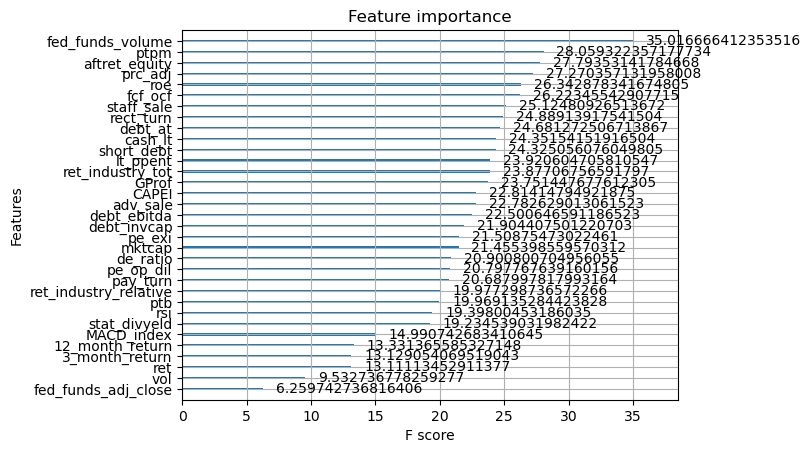

In [143]:
# gain is usually the most realiable metric to evaluate the importance of the features
xgb.plot_importance(model, importance_type='gain')

Period: 2008-01-01 00:00:00

Training features:
['stat_divyeld', '12_month_return', '3_month_return', 'fed_funds_volume', 'CAPEI', 'de_ratio', 'debt_ebitda', 'pe_op_dil', 'pe_exi', 'staff_sale', 'ptpm', 'GProf', 'roe', 'debt_invcap', 'aftret_equity', 'cash_lt', 'debt_at', 'short_debt', 'fcf_ocf', 'lt_ppent', 'ptb', 'rect_turn', 'pay_turn', 'adv_sale', 'mktcap', 'ret_industry_tot', 'MACD_index', 'vol', 'ret', 'prc_adj', 'rsi', 'ret_industry_relative', 'fed_funds_adj_close']
First trading date: 2010-01-04 00:00:00
Return date: 2010-04-01 00:00:00


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%),target
0,10104,0.460348,0.539652,1,True,7.387719,10104,8.017096,8.519228,1.0
1,10107,0.354211,0.645789,1,False,5.227479,10107,5.066826,-3.073245,0.0
2,10137,0.252027,0.747973,1,True,6.912729,10137,7.076487,2.368937,1.0
3,10138,0.882017,0.117983,0,False,19.628916,10138,20.278299,3.308297,1.0
4,10145,0.246122,0.753878,1,True,7.657640,10145,9.767455,27.551752,1.0
...,...,...,...,...,...,...,...,...,...,...
611,92618,0.667503,0.332496,0,False,4.033691,92618,5.131214,27.208895,1.0
612,92655,0.225501,0.774499,1,True,4.322705,92655,4.918431,13.781331,1.0
613,92709,0.050195,0.949805,1,True,12.536904,92709,13.989544,11.586908,1.0
614,92772,0.157326,0.842674,1,True,3.685129,92772,4.407173,19.593424,1.0


Top 15 long predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
26,11891,0.001496,0.998504,1,True,4.792539,11891,6.322027,31.913939
424,81774,0.007124,0.992876,1,True,25.725390,81774,27.131288,5.465023
602,92121,0.011210,0.988790,1,False,4.448738,92121,4.364759,-1.887705
134,26710,0.012009,0.987991,1,True,16.075398,26710,16.569560,3.074028
543,89509,0.013403,0.986597,1,True,23.264609,89509,26.846428,15.395998
41,13901,0.013523,0.986477,1,True,5.897211,13901,6.292744,6.707110
361,77037,0.016277,0.983723,1,True,1.395639,77037,2.162179,54.923942
274,61399,0.021494,0.978506,1,True,4.921714,61399,5.129753,4.226967
455,84761,0.022086,0.977914,1,False,2.698849,84761,2.412656,-10.604247
421,81677,0.023879,0.976121,1,False,5.254357,81677,5.208475,-0.873221


----------------------------------------------------------
Top 15 short predictions:


,permno,0_probability,1_probability,prediction,correct_prediction,trading_day_price,permnos,price_return,return(%)
531,89031,0.984318,0.015682,0,False,0.958072,89031,1.082119,12.947561
545,89533,0.976765,0.023235,0,False,44.379181,89533,57.849720,30.353283
273,61241,0.975484,0.024516,0,True,2.989433,61241,2.897434,-3.077444
240,53225,0.971824,0.028176,0,False,148.947235,53225,151.894389,1.978656
270,60871,0.958390,0.041610,0,True,9.795606,60871,8.716465,-11.016583
542,89508,0.957596,0.042404,0,False,10.812147,89508,11.046951,2.171673
76,20415,0.955443,0.044557,0,False,10.968898,20415,11.396933,3.902260
50,15202,0.954640,0.045360,0,True,15.981213,15202,14.000952,-12.391180
493,86964,0.949422,0.050578,0,False,53.980000,86964,62.140000,15.116710
567,90505,0.947999,0.052001,0,False,11.371603,90505,16.115949,41.720995


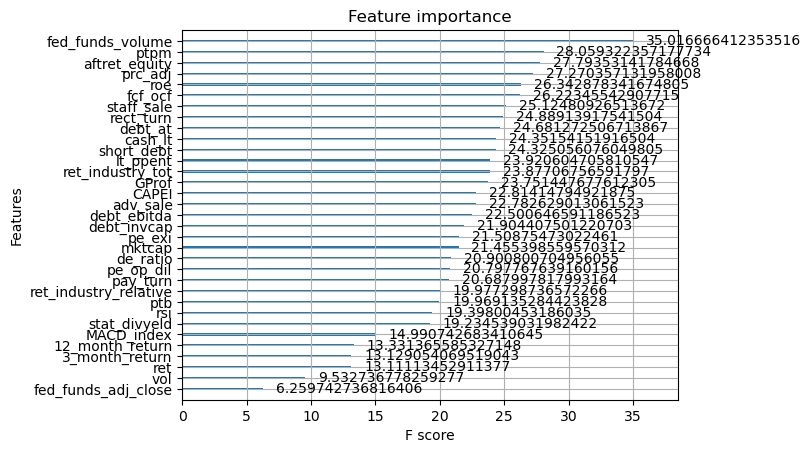


-----------------------------------------------------------------------------------------------------------------
Period: 2010-01-01 00:00:00

Training features:
['divyield', '12_month_return', '3_month_return', 'fed_funds_volume', 'CAPEI', 'staff_sale', 'debt_ebitda', 'pe_op_dil', 'pe_exi', 'ptpm', 'GProf', 'roe', 'aftret_invcapx', 'aftret_eq', 'debt_invcap', 'cash_lt', 'debt_at', 'fcf_ocf', 'dltt_be', 'de_ratio', 'rect_turn', 'pay_turn', 'ptb', 'adv_sale', 'prc', 'retx', 'naics_processed', 'MACD_index', 'vol', 'ret', 'prc_adj', 'rsi', 'ret_industry_relative', 'fed_funds_adj_close']


FileNotFoundError: [Errno 2] No such file or directory: '../../models/xg_boost_2010-01-01_300_correct_dataset.pkl'

In [146]:
for period in selected_features:
    print(f'Period: {period}\n')
    start_date = pd.to_datetime(period)
    end_date = start_date + pd.DateOffset(years=2) - pd.DateOffset(days=91)

    training_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
    training_features = selected_features[start_date]

    # print the features
    print(f'Training features:\n{training_features}')

    X = training_data[training_features].copy()
    y = training_data['target'].copy()
    negative_mask = (y == -1)
    y[negative_mask] = 0

    # import the model with pickle
    n_estimators = 300
    start_date_str = start_date.strftime('%Y-%m-%d')
    model_name = f'xg_boost_{start_date_str}_{n_estimators}_correct_dataset.pkl'
    with open(f'../../models/{model_name}', 'rb') as f:
        model = pickle.load(f)

    first_trading_date = start_date + pd.DateOffset(years=2)
    dates = data['date'].unique()

    # find the first trading day after the end date
    while first_trading_date not in dates:
        first_trading_date += pd.DateOffset(days=1)

    print(f'First trading date: {first_trading_date}')

    X_prediction_mask = data['date'] == first_trading_date
    X_prediction = data[X_prediction_mask][training_features].copy()

    assert len(X_prediction) > 0, 'No data to predict'
    permnos_first_trading_day = data[X_prediction_mask]['permno'].copy()
    target = data[X_prediction_mask]['target'].copy()
    target[target == -1] = 0


    return_date = first_trading_date + pd.DateOffset(days=90)

    # find the first trading day after the end date
    while return_date not in dates:
        return_date -= pd.DateOffset(days=1)

    print(f'Return date: {return_date}')

    X_return_mask = price_data['date'] == return_date
    X_prediction_mask = price_data['date'] == first_trading_date

    # calculate 90 days return
    trading_day_price = price_data[X_prediction_mask][['permno', 'prc_adj']].copy()
    return_day_price = price_data[X_return_mask]['prc_adj'].copy()
    permnos_return = price_data[X_return_mask]['permno'].copy()


    # find the predictions
    y_pred_proba = model.predict_proba(X_prediction)
    y_pred = model.predict(X_prediction)

    # check if prediction is correct
    correct_prediction = y_pred == target

    # put the predictions in a dataframe
    predictions_df = pd.DataFrame({
        'permno': permnos_first_trading_day,
        '0_probability': y_pred_proba[:, 0],
        '1_probability': y_pred_proba[:, 1],
        'prediction': y_pred,
        'correct_prediction': correct_prediction
    })
    trading_day_price.rename(columns={'prc_adj': 'trading_day_price'}, inplace=True)
    predictions_df = pd.merge(predictions_df, trading_day_price, left_on='permno', right_on='permno', how='inner')

    return_price_df = pd.DataFrame({
        'permnos': permnos_return,
        'price_return': return_day_price,
    })

    # merge the two dataframes
    merged_df = pd.merge(predictions_df, return_price_df, left_on='permno', right_on='permnos')

    # calculate the return
    merged_df['return(%)'] = (merged_df['price_return'] / merged_df['trading_day_price'] - 1)*100


    # Sanity check to see if everything lines up 
    merged_df_2 = pd.merge(merged_df, price_data[price_data['date'] == first_trading_date][['permno', 'target']], left_on='permno', right_on='permno')
    display(merged_df_2)



    n = 15
    # find the n argmin and argmax
    top_n = merged_df['1_probability'].nlargest(n)
    bottom_n = merged_df['1_probability'].nsmallest(n)

    #features_to_print = ['permno','0_probability', '1_probability', 'correct_prediction', 'return(%)']

    print(f'Top {n} long predictions:')
    display(merged_df.loc[top_n.index])#[features_to_print])
    print('-'*58)
    print(f'Top {n} short predictions:')
    display(merged_df.loc[bottom_n.index])#[features_to_print])


    # gain is usually the most realiable metric to evaluate the importance of the features
    xgb.plot_importance(model, importance_type='gain')
    plt.show()

    print('')
    print('-----------------------------------------------------------------------------------------------------------------')
    